# Import

In [1]:
import numpy as np
print(f'numpy version = {np.__version__}')

import tensorflow as tf
print(f'tensorflow version = {tf.__version__}')

numpy version = 1.22.4
tensorflow version = 2.6.0


In [2]:
import os
import cv2
import csv
import sys
import math
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TerminateOnNaN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import regularizers

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
seed_value = 10  #origine

# seed_value = 42 #[RandomSeed]
# seed_value = 0
# seed_value = 20
# seed_value = 123
# seed_value = 12321
# seed_value = 100
# seed_value = 64
# seed_value = 200
# seed_value = 456
# seed_value = 1001

os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# GPU Setting

In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Global Variables

In [6]:
KeypointsROOT = "../../4_Cut_Video/data/"
n_FOLD = 5
n_GAP = 30
n_PERIOD = 50
n_FEATURE = 12 
n_SELECTED_FEATURE = 9
selected_features = [3, 4, 5, 6, 7, 8, 9, 10, 11]

# remove_dementia_pid_list = [22, 33, 57, 58, 64, 66, 67]
# remove_dementia_pid_list_str = ['22', '33', '57', '58', '64', '66', '67']

In [7]:
# DATE = "20240620"
DATE = "20240821"


flag_MMSE = False
flag_MMSE_Scaled = False
flag_CDR = False
flag_CDR_Scaled = False
flag_CDRSOB = True
flag_CDRSOB_Scaled = False

flag_PreTrained = True


# Load Label

In [8]:
excel_path = "../Label_Data_Info.xlsx"

df_Label = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', '_Label'])
df_Label = df_Label.fillna(0)
df_Label = df_Label.astype({"_Label": int})
df_Label = df_Label.rename(columns={'_Label': 'label'})
Label_dict = dict(zip(df_Label.編號, df_Label.label))

print(Label_dict)

{1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 1, 19: 0, 20: 1, 21: 0, 22: 0, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 0, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 1, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 1, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 1, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0}


# Load MMSE/CDR/CDRSOB score

In [9]:
excel_path = "../Score_Data_Info.xlsx"

df_MMSE = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', 'MMSE/總分30'])
df_MMSE = df_MMSE.fillna(0)
df_MMSE = df_MMSE.astype({"MMSE/總分30": int})
df_MMSE = df_MMSE.rename(columns={'MMSE/總分30': 'MMSE'})
MMSE_dict = dict(zip(df_MMSE.編號, df_MMSE.MMSE))

df_CDR = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', 'my_CDR'])
df_CDR = df_CDR.fillna(0)
df_CDR = df_CDR.astype({"my_CDR": float})
df_CDR = df_CDR.rename(columns={'my_CDR': 'CDR'})
CDR_dict = dict(zip(df_CDR.編號, df_CDR.CDR))

df_CDRSOB = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', 'my_CDRSOB'])
df_CDRSOB = df_CDRSOB.fillna(0)
df_CDRSOB = df_CDRSOB.astype({"my_CDRSOB": float})
df_CDRSOB = df_CDRSOB.rename(columns={'my_CDRSOB': 'CDRSOB'})
CDRSOB_dict = dict(zip(df_CDRSOB.編號, df_CDRSOB.CDRSOB))

print(CDRSOB_dict)

{1: 0.0, 2: 0.0, 3: 0.0, 4: 1.5, 5: 1.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 6.0, 10: 1.0, 11: 9.0, 12: 1.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 3.0, 17: 1.0, 18: 1.5, 19: 2.5, 20: 3.0, 21: 0.0, 22: 0.0, 23: 6.0, 24: 1.5, 25: 3.0, 26: 1.0, 27: 4.0, 28: 0.5, 29: 0.0, 30: 0.0, 31: 1.0, 32: 2.0, 33: 8.0, 34: 0.0, 35: 2.5, 36: 8.0, 37: 1.5, 38: 0.5, 39: 2.0, 40: 1.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 1.5, 46: 0.0, 47: 0.0, 48: 2.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 1.0, 58: 1.0, 59: 1.0, 60: 5.0, 61: 1.5, 62: 4.0, 63: 2.5, 64: 5.0, 65: 1.0, 66: 4.5, 67: 0.5, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0}


# Normalize Score

In [10]:
MMSE_scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_MMSE_score(data):
    pidList = []
    score = []
    for key in data:
        pidList.append(key)
        score.append(data[key])
    score = np.array(score)
    score_scaled = MMSE_scaler.fit_transform(score.reshape(-1, 1))
    score_scaled = score_scaled.reshape(-1)

    tmp_dict = {}
    for i, pid in enumerate(pidList):
        tmp_dict[pid] = score_scaled[i]
    return tmp_dict

MMSE_dict_scaled = normalize_MMSE_score(MMSE_dict)

In [11]:
CDR_scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_CDR_score(data):
    pidList = []
    score = []
    for key in data:
        pidList.append(key)
        score.append(data[key])
    score = np.array(score)
    score_scaled = CDR_scaler.fit_transform(score.reshape(-1, 1))
    score_scaled = score_scaled.reshape(-1)

    tmp_dict = {}
    for i, pid in enumerate(pidList):
        tmp_dict[pid] = score_scaled[i]
    return tmp_dict

CDR_dict_scaled = normalize_CDR_score(CDR_dict)

In [12]:
CDRSOB_scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_CDRSOB_score(data):
    pidList = []
    score = []
    for key in data:
        pidList.append(key)
        score.append(data[key])
    score = np.array(score)
    score_scaled = CDRSOB_scaler.fit_transform(score.reshape(-1, 1))
    score_scaled = score_scaled.reshape(-1)

    tmp_dict = {}
    for i, pid in enumerate(pidList):
        tmp_dict[pid] = score_scaled[i]
    return tmp_dict

CDRSOB_dict_scaled = normalize_CDRSOB_score(CDRSOB_dict)
print(CDRSOB_dict_scaled)

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.16666666666666666, 5: 0.1111111111111111, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.6666666666666666, 10: 0.1111111111111111, 11: 1.0, 12: 0.1111111111111111, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.3333333333333333, 17: 0.1111111111111111, 18: 0.16666666666666666, 19: 0.2777777777777778, 20: 0.3333333333333333, 21: 0.0, 22: 0.0, 23: 0.6666666666666666, 24: 0.16666666666666666, 25: 0.3333333333333333, 26: 0.1111111111111111, 27: 0.4444444444444444, 28: 0.05555555555555555, 29: 0.0, 30: 0.0, 31: 0.1111111111111111, 32: 0.2222222222222222, 33: 0.8888888888888888, 34: 0.0, 35: 0.2777777777777778, 36: 0.8888888888888888, 37: 0.16666666666666666, 38: 0.05555555555555555, 39: 0.2222222222222222, 40: 0.1111111111111111, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.16666666666666666, 46: 0.0, 47: 0.0, 48: 0.2222222222222222, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.1111111111111111, 58: 0.1111111111111111, 59: 0.1111111111111111, 60: 0.55555555555555

# Load Subject ID

In [13]:
def load_id(KeypointsROOT):
    allID = []
    for folder in list(os.listdir(KeypointsROOT)):
        # if folder not in remove_dementia_pid_list_str:
        if folder!="50":
            allID.append(folder)
    return allID


allID_list = load_id(KeypointsROOT)

print(f'[Info] # of pid: {len(allID_list)}\n')
print(allID_list)

[Info] # of pid: 88

['01', '02', '03', '04', '05', '06', '07', '09', '10', '100', '11', '12', '13', '16', '17', '18', '19', '20', '21', '22', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '43', '44', '45', '46', '48', '49', '51', '52', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


# Split Subject ID

In [14]:
def load_split_id_5fold_from_csv_file():
    train_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/walk_train_5fold.csv'
    val_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/walk_val_5fold.csv'
    test_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/walk_test_5fold.csv'

    tmp_trainID_5f = []
    tmp_valID_5f = []
    tmp_testID_5f = []
    
    file_train = open(train_csv, "r")
    tmp_trainID_5f = list(csv.reader(file_train, delimiter=","))
    file_train.close()
    
    file_val = open(val_csv, "r")
    tmp_valID_5f = list(csv.reader(file_val, delimiter=","))
    file_val.close()
    
    file_test = open(test_csv, "r")
    tmp_testID_5f = list(csv.reader(file_test, delimiter=","))
    file_test.close()
    return tmp_trainID_5f, tmp_valID_5f, tmp_testID_5f



trainID_5f, validateID_5f, testID_5f = load_split_id_5fold_from_csv_file()

for i in range(n_FOLD):
    print(f'[Fold {i+1}] Total: {len(trainID_5f[i])+len(validateID_5f[i])+len(testID_5f[i])} subjects.')
    print(f'-Train: (num: {len(trainID_5f[i])})\n{trainID_5f[i]}')
    print(f'-Validate: (num: {len(validateID_5f[i])})\n{validateID_5f[i]}')
    print(f'-Test: (num: {len(testID_5f[i])})\n{testID_5f[i]}\n')    

[Fold 1] Total: 88 subjects.
-Train: (num: 56)
['17', '18', '20', '24', '25', '26', '27', '28', '31', '32', '33', '35', '38', '39', '40', '43', '46', '48', '51', '52', '57', '58', '60', '61', '62', '63', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '76', '77', '78', '79', '80', '82', '84', '85', '86', '87', '88', '90', '91', '92', '93', '95', '96', '97', '98', '99']
-Validate: (num: 14)
['03', '05', '06', '07', '09', '10', '100', '12', '13', '16', '19', '21', '22', '30']
-Test: (num: 18)
['01', '02', '04', '11', '29', '34', '36', '37', '44', '45', '49', '59', '67', '75', '81', '83', '89', '94']

[Fold 2] Total: 88 subjects.
-Train: (num: 56)
['17', '18', '20', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '36', '37', '38', '39', '40', '44', '45', '46', '48', '49', '51', '57', '58', '59', '60', '63', '64', '67', '68', '69', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '83', '84', '85', '86', '88', '89', '92', '94', '95', '97', '98', '99'

In [15]:
# def remove_dementia_pid_from_data(train, val, test):
#     new_train_5f, new_val_5f, new_test_5f = [], [], []
#     for i in range(n_FOLD):
#         train_1f = train[i]
#         val_1f = val[i]
#         test_1f = test[i]

#         new_train, new_val, new_test = [], [], []

#         for idx, pid in enumerate(train_1f):
#             if pid not in remove_dementia_pid_list_str: new_train.append(pid)
#         for idx, pid in enumerate(val_1f):
#             if pid not in remove_dementia_pid_list_str: new_val.append(pid)
#         for idx, pid in enumerate(test_1f):
#             if pid not in remove_dementia_pid_list_str: new_test.append(pid)
#         new_train_5f.append(new_train)
#         new_val_5f.append(new_val)
#         new_test_5f.append(new_test)
#     return new_train_5f, new_val_5f, new_test_5f

# trainID_5f, validateID_5f, testID_5f = remove_dementia_pid_from_data(trainID_5f, validateID_5f, testID_5f)

In [16]:
def check_walking_subtask_pid(train_5f, val_5f, test_5f):
    ### check if all subjects are tested
    tmp_set = set()
    for i in range(n_FOLD):
        test_1f = test_5f[i]
        for j in range(len(test_1f)):
            pid = test_1f[j]
            tmp_set.add(pid)
    print(f'Number of pid in Test Set: {len(tmp_set)} subjects.\n')
    
    ### Check each fold (train + val + test)
    print(f'[Info] Check for each fold ...')
    for i in range(n_FOLD):
        tmp_set = set()
        for j in range(len(train_5f[i])):
            tmp_set.add(train_5f[i][j])
        for j in range(len(val_5f[i])):
            tmp_set.add(val_5f[i][j])
        for j in range(len(test_5f[i])):
            tmp_set.add(test_5f[i][j])
        print(f' -fold {i+1}: {len(tmp_set)} subjects.')


check_walking_subtask_pid(trainID_5f, validateID_5f, testID_5f)  

Number of pid in Test Set: 88 subjects.

[Info] Check for each fold ...
 -fold 1: 88 subjects.
 -fold 2: 88 subjects.
 -fold 3: 88 subjects.
 -fold 4: 88 subjects.
 -fold 5: 88 subjects.


# Load Coordinate Data

In [17]:
def normalize_segment(segment):
    n_row, n_col = segment.shape[0], segment.shape[1]

    for i in range(n_col):
        tmpList = [row[i] for row in segment]
        
        tmpArray = np.array(tmpList)
        tmpArray = tmpArray.reshape(len(tmpArray), 1)
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaledArray = scaler.fit_transform(tmpArray)
        scaledArray = scaledArray.reshape(-1)
        if i==0:
            resultArray = scaledArray
        else:
            resultArray = np.vstack((resultArray, scaledArray))

    dataScaled = []
    nFrames = resultArray.shape[1]
    for i in range(nFrames):
        dataScaled.append([resultArray[0][i], resultArray[1][i],
                            resultArray[2][i], resultArray[3][i],
                            resultArray[4][i], resultArray[5][i],
                            resultArray[6][i], resultArray[7][i],
                            resultArray[8][i], resultArray[9][i],
                            resultArray[10][i], resultArray[11][i]])
    dataScaled = np.array(dataScaled)
    return dataScaled


def create_one_pid_all_segments_data(pid, pts, video_cut):
    n_frame = len(pts)
    n_pair = int((n_frame - int(n_PERIOD)) / int(n_GAP)) + 1 

    start, end = 0, 0
    idxData, xData, yData = [], [], []
    segmentIdx, videoIdx = [], [] ### UPDATE [2024/03/02]
    for i in range(n_pair):
        end = start + int(n_PERIOD)
        
        x = pts[start:end, :]
        x = normalize_segment(x)
        
        x = np.transpose(x).astype(np.float32)

        if flag_MMSE: y = MMSE_dict[int(pid)]
        elif flag_MMSE_Scaled: y = MMSE_dict_scaled[int(pid)]
        elif flag_CDR: y = CDR_dict[int(pid)]
        elif flag_CDR_Scaled: y = CDR_dict_scaled[int(pid)]
        elif flag_CDRSOB: y = CDRSOB_dict[int(pid)]
        elif flag_CDRSOB_Scaled: y = CDRSOB_dict_scaled[int(pid)]
        
        xData.append(x)
        yData.append(y)
        idxData.append(int(pid))
        segmentIdx.append(i)
        videoIdx.append(video_cut)

        start += int(n_GAP)   
    return idxData, xData, yData, segmentIdx, videoIdx


def load_data_5fold_normalized_by_segment(KeypointsROOT, trainID, validateID, testID):
    idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
    idxValidate_5f, xValidate_5f, yValidate_5f = [], [], []
    idxTest_5f, xTest_5f, yTest_5f = [], [], []

    segmentIdx_5f = [] ### UPDATE [2024/03/02]: Only works on Test Data
    videoIdx_5f = []
    
    for i in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = [], [], []
        idxValidate_1f, xValidate_1f, yValidate_1f = [], [], []
        idxTest_1f, xTest_1f, yTest_1f = [], [], []

        segmentIdx_1f = [] ### UPDATE [2024/03/02]: Only works on Test Data
        videoIdx_1f = []
        
        train_index = trainID[i]
        validate_index = validateID[i]
        test_index = testID[i]
        
        ### ============================================================= Train =============================================================
        for idx in train_index:
            csv_cut1_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut1_keypoints1_3.csv'
            csv_cut2_M_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut2_keypoints1_3.csv'
            if not os.path.exists(csv_cut1_norm):
                print(f'{idx} [cut1] CSV does not exist.')
            else:
                df = pd.read_csv(csv_cut1_norm, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut1")
                idxTrain_1f.extend(idxData)
                xTrain_1f.extend(xData) 
                yTrain_1f.extend(yData)
            if not os.path.exists(csv_cut2_M_norm):
                print(f'{idx} [cut2 Mirrored] CSV does not exist.')
            else:
                df = pd.read_csv(csv_cut2_M_norm, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut2M")
                idxTrain_1f.extend(idxData)
                xTrain_1f.extend(xData)
                yTrain_1f.extend(yData)
        
        idxTrain_5f.append(idxTrain_1f)
        xTrain_5f.append(xTrain_1f)
        yTrain_5f.append(yTrain_1f)
        
        ### ============================================================= Validation =============================================================
        for idx in validate_index:
            csv_cut1_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut1_keypoints1_3.csv'
            csv_cut2_M_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut2_keypoints1_3.csv'
            
            if not os.path.exists(csv_cut1_norm):
                print(f'{idx} [cut1] CSV does not exist.')
            else:
                df = pd.read_csv(csv_cut1_norm, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut1")
                idxValidate_1f.extend(idxData)
                xValidate_1f.extend(xData)
                yValidate_1f.extend(yData)
            if not os.path.exists(csv_cut2_M_norm):
                print(f'{idx} [cut2 Mirrored] CSV does not exist.')
            else:
                df = pd.read_csv(csv_cut2_M_norm, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut2M")
                idxValidate_1f.extend(idxData)
                xValidate_1f.extend(xData)
                yValidate_1f.extend(yData)
        
        idxValidate_5f.append(idxValidate_1f)
        xValidate_5f.append(xValidate_1f)
        yValidate_5f.append(yValidate_1f)
        
        ### ============================================================= Test =============================================================
        for idx in test_index:
            csv_cut1_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut1_keypoints1_3.csv'
            csv_cut2_M_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut2_keypoints1_3.csv'
            
            if not os.path.exists(csv_cut1_norm):
                print(f'[Test] {idx} [cut1] CSV does not exist.')
            else:
                df = pd.read_csv(csv_cut1_norm, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut1")
                idxTest_1f.extend(idxData)
                xTest_1f.extend(xData)
                yTest_1f.extend(yData)
                segmentIdx_1f.extend(segmentIdx) ### UPDATE [2024/03/02]
                videoIdx_1f.extend(videoIdx)
            if not os.path.exists(csv_cut2_M_norm):
                print(f'[Test] {idx} [cut2 Mirrored] CSV does not exist.')
            else:
                df = pd.read_csv(csv_cut2_M_norm, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut2M")
                idxTest_1f.extend(idxData)
                xTest_1f.extend(xData)
                yTest_1f.extend(yData) 
                segmentIdx_1f.extend(segmentIdx) ### UPDATE [2024/03/02]
                videoIdx_1f.extend(videoIdx)

        idxTest_5f.append(idxTest_1f)
        xTest_5f.append(xTest_1f)
        yTest_5f.append(yTest_1f)
        segmentIdx_5f.append(segmentIdx_1f) ### UPDATE [2024/03/02]
        videoIdx_5f.append(videoIdx_1f)
    return idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f, videoIdx_5f

In [18]:
print(f'[INFO] Normalize data by each segment.')
idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f, videoIdx_5f \
        = load_data_5fold_normalized_by_segment(KeypointsROOT, trainID_5f, validateID_5f, testID_5f)

[INFO] Normalize data by each segment.


In [19]:
for i in range(n_FOLD):
    ### ========================= Train =========================
    tmpIdx_train = np.array(idxTrain_5f[i])
    tmpX_train = np.array(xTrain_5f[i])
    tmpY_train = np.array(yTrain_5f[i])
    
    tmpIdx_train, tmpX_train, tmpY_train = shuffle(tmpIdx_train, tmpX_train, tmpY_train)
    
    idxTrain_5f[i] = tmpIdx_train
    xTrain_5f[i] = tmpX_train
    yTrain_5f[i] = tmpY_train
    
    ### ========================= Validation =========================
    tmpIdx_val = np.array(idxValidate_5f[i])
    tmpX_val = np.array(xValidate_5f[i])
    tmpY_val = np.array(yValidate_5f[i])
    
    tmpIdx_val, tmpX_val, tmpY_val = shuffle(tmpIdx_val, tmpX_val, tmpY_val)
    
    idxValidate_5f[i] = tmpIdx_val
    xValidate_5f[i] = tmpX_val
    yValidate_5f[i] = tmpY_val
    
    ### ========================= Test =========================
    tmpIdx_test = np.array(idxTest_5f[i])
    tmpX_test = np.array(xTest_5f[i])
    tmpY_test = np.array(yTest_5f[i])
    tmpSegIdx_test = np.array(segmentIdx_5f[i])
    tmpVideoIdx_test = np.array(videoIdx_5f[i])
    
    ### UPDATE [2024/03/02] Do NOT shuffle the Testing data
    tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test, tmpVideoIdx_test = shuffle(tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test, tmpVideoIdx_test)
    
    idxTest_5f[i] = tmpIdx_test
    xTest_5f[i] = tmpX_test
    yTest_5f[i] = tmpY_test
    segmentIdx_5f[i] = tmpSegIdx_test
    videoIdx_5f[i] = tmpVideoIdx_test

print(f'[Input Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {xTrain_5f[i].shape}, (Validate): {xValidate_5f[i].shape}, (Test): {xTest_5f[i].shape}')

print(f'\n[Target Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {yTrain_5f[i].shape}, (Validate): {yValidate_5f[i].shape}, (Test): {yTest_5f[i].shape}, (SegIdx): {segmentIdx_5f[i].shape}, (VideoIdx): {videoIdx_5f[i].shape}')

[Input Data]
- Fold 1 (Train): (329, 12, 50), (Validate): (87, 12, 50), (Test): (103, 12, 50)
- Fold 2 (Train): (329, 12, 50), (Validate): (73, 12, 50), (Test): (117, 12, 50)
- Fold 3 (Train): (330, 12, 50), (Validate): (86, 12, 50), (Test): (103, 12, 50)
- Fold 4 (Train): (327, 12, 50), (Validate): (99, 12, 50), (Test): (93, 12, 50)
- Fold 5 (Train): (325, 12, 50), (Validate): (91, 12, 50), (Test): (103, 12, 50)

[Target Data]
- Fold 1 (Train): (329,), (Validate): (87,), (Test): (103,), (SegIdx): (103,), (VideoIdx): (103,)
- Fold 2 (Train): (329,), (Validate): (73,), (Test): (117,), (SegIdx): (117,), (VideoIdx): (117,)
- Fold 3 (Train): (330,), (Validate): (86,), (Test): (103,), (SegIdx): (103,), (VideoIdx): (103,)
- Fold 4 (Train): (327,), (Validate): (99,), (Test): (93,), (SegIdx): (93,), (VideoIdx): (93,)
- Fold 5 (Train): (325,), (Validate): (91,), (Test): (103,), (SegIdx): (103,), (VideoIdx): (103,)


# Feature Selection

In [20]:
def feature_selection_reconstruct_data(train, val, test):
    tmp_xTrain_5f, tmp_xVal_5f, tmp_xTest_5f = [], [], []
    for fold_idx in range(n_FOLD):
        xTrain_1f = train[fold_idx]
        xVal_1f = val[fold_idx]
        xTest_1f = test[fold_idx]

        tmp_xTrain_1f, tmp_xVal_1f, tmp_xTest_1f = [], [], []

        top_feature_idx = selected_features

        for data in xTrain_1f:
            data = data[top_feature_idx]
            tmp_xTrain_1f.append(data)
        tmp_xTrain_1f = np.array(tmp_xTrain_1f)
        tmp_xTrain_5f.append(tmp_xTrain_1f)
        
        for data in xVal_1f:
            data = data[top_feature_idx]
            tmp_xVal_1f.append(data)
        tmp_xVal_1f = np.array(tmp_xVal_1f)
        tmp_xVal_5f.append(tmp_xVal_1f)

        for data in xTest_1f:
            data = data[top_feature_idx]
            tmp_xTest_1f.append(data)
        tmp_xTest_1f = np.array(tmp_xTest_1f)
        tmp_xTest_5f.append(tmp_xTest_1f)
    return tmp_xTrain_5f, tmp_xVal_5f, tmp_xTest_5f


xTrain_5f, xValidate_5f, xTest_5f = feature_selection_reconstruct_data(xTrain_5f, xValidate_5f, xTest_5f)

In [21]:
print(f'[Input Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {xTrain_5f[i].shape}, (Validate): {xValidate_5f[i].shape}, (Test): {xTest_5f[i].shape}')

print(f'\n[Target Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {yTrain_5f[i].shape}, (Validate): {yValidate_5f[i].shape}, (Test): {yTest_5f[i].shape}, (SegIdx): {segmentIdx_5f[i].shape}, (VideoIdx): {videoIdx_5f[i].shape}')

[Input Data]
- Fold 1 (Train): (329, 9, 50), (Validate): (87, 9, 50), (Test): (103, 9, 50)
- Fold 2 (Train): (329, 9, 50), (Validate): (73, 9, 50), (Test): (117, 9, 50)
- Fold 3 (Train): (330, 9, 50), (Validate): (86, 9, 50), (Test): (103, 9, 50)
- Fold 4 (Train): (327, 9, 50), (Validate): (99, 9, 50), (Test): (93, 9, 50)
- Fold 5 (Train): (325, 9, 50), (Validate): (91, 9, 50), (Test): (103, 9, 50)

[Target Data]
- Fold 1 (Train): (329,), (Validate): (87,), (Test): (103,), (SegIdx): (103,), (VideoIdx): (103,)
- Fold 2 (Train): (329,), (Validate): (73,), (Test): (117,), (SegIdx): (117,), (VideoIdx): (117,)
- Fold 3 (Train): (330,), (Validate): (86,), (Test): (103,), (SegIdx): (103,), (VideoIdx): (103,)
- Fold 4 (Train): (327,), (Validate): (99,), (Test): (93,), (SegIdx): (93,), (VideoIdx): (93,)
- Fold 5 (Train): (325,), (Validate): (91,), (Test): (103,), (SegIdx): (103,), (VideoIdx): (103,)


# Define Loss Function

In [22]:
# def correlation_coefficient_loss(y_true, y_pred):
#     """
#     Calculate the negative correlation coefficient between y_true and y_pred.
#     The loss value should be minimized, so we return the negative of the correlation coefficient.
#     """
#     x = y_true
#     y = y_pred
    
#     mx = K.mean(x)
#     my = K.mean(y)
    
#     xm, ym = x - mx, y - my
#     r_num = K.sum(xm * ym)
#     r_den = K.sqrt(K.sum(K.square(xm)) * K.sum(K.square(ym)))
#     r = r_num / r_den
#     return -r  # We return the negative of the correlation coefficient to fit into the loss paradigm.

# Training

In [23]:
# if flag_MMSE:
#     MAX_EPOCHS = 200
#     BATCH_SIZE = 32
# if flag_CDR or flag_CDRSOB:
#     MAX_EPOCHS = 50
#     BATCH_SIZE = 32

MAX_EPOCHS = 50
BATCH_SIZE = 32

# Original Score
# SAVE_MODEL_FOLDER = "LOG_Walking/MMSE/20240613_Adam_LossMAE_metricsMAE/"
# SAVE_MODEL_FOLDER = "LOG_Walking/CDR/20240613_Adam_LossMAE_metricsMAE/"
# SAVE_MODEL_FOLDER = "LOG_Walking/CDRSOB/20240613_Adam_LossMAE_metricsMAE/"

### Scaled Score
# SAVE_MODEL_FOLDER = "LOG_Walking/MMSE_Scaled/20240613_Adam_LossMAE_metricsMAE/"
# SAVE_MODEL_FOLDER = "LOG_Walking/CDR_Scaled/20240613_Adam_LossMAE_metricsMAE/"
# SAVE_MODEL_FOLDER = "LOG_Walking/CDRSOB_Scaled/20240613_Adam_LossMAE_metricsMAE/"

if flag_PreTrained==False:
    if flag_MMSE: 
        SAVEMODEL_FOLDER = "LOG_Walking/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: 
        SAVEMODEL_FOLDER = "LOG_Walking/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: 
        SAVEMODEL_FOLDER = "LOG_Walking/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: 
        SAVEMODEL_FOLDER = "LOG_Walking/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: 
        SAVEMODEL_FOLDER = "LOG_Walking/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: 
        SAVEMODEL_FOLDER = "LOG_Walking/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"

elif flag_PreTrained==True:
    if flag_MMSE: 
        SAVEMODEL_FOLDER = "LOG_Walking_PreTrained/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: 
        SAVEMODEL_FOLDER = "LOG_Walking_PreTrained/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: 
        SAVEMODEL_FOLDER = "LOG_Walking_PreTrained/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: 
        SAVEMODEL_FOLDER = "LOG_Walking_PreTrained/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: 
        SAVEMODEL_FOLDER = "LOG_Walking_PreTrained/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: 
        SAVEMODEL_FOLDER = "LOG_Walking_PreTrained/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"


print(f'Save model weights to FOLDER: {SAVEMODEL_FOLDER}')

Save model weights to FOLDER: LOG_Walking_PreTrained/CDRSOB/20240821_Adam_LossMAE_metricsMAE/


In [24]:
def build_model_structure():
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(1, 3), activation='relu', strides=1, padding='same', input_shape=(int(n_SELECTED_FEATURE), int(n_PERIOD), 1), name='first_conv'))
    model.add(Conv2D(16, kernel_size=(1, 3), activation='relu', strides=1, padding='same', name='last_conv'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    # model.add(Dense(32, activation='relu', 
    #                 kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-5), 
    #                 bias_regularizer=regularizers.L2(1e-4), 
    #                 activity_regularizer=regularizers.L2(1e-4)))
    # model.add(Dense(32, activation='relu', kernel_regularizer=l1(0.15)))
    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.1, l2=0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    return model


def training_model_Validation_data_Save_model():
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], xValidate_5f[fold_idx], yValidate_5f[fold_idx]

        xTrain_1f = xTrain_1f.reshape(-1, int(n_SELECTED_FEATURE), int(n_PERIOD), 1)
        xVal_1f = xVal_1f.reshape(-1, int(n_SELECTED_FEATURE), int(n_PERIOD), 1)

        print(f'Training for [Fold {fold_idx+1}] .....')

        if flag_PreTrained==False:
            model = build_model_structure()
        elif flag_PreTrained==True:
            LOAD_PRETRAINED = "../Walking Subtask/LOG_FS/Walking_RandomSeed_FS/10/Model_Weights/"
            pretrained_model = load_model(f"{LOAD_PRETRAINED}walking_model_Fold{fold_idx+1}.h5")
            for layer in pretrained_model.layers[:-3]:
                layer.trainable = False
            x = pretrained_model.layers[-4].output
            x = Dense(32, 
                      activation='relu', 
                      name='dense_32', 
                      kernel_regularizer=l1(0.01)
                    #   kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                    #   bias_regularizer=regularizers.L2(1e-3),
                    #   activity_regularizer=regularizers.L2(1e-3)
                      )(x)
            x = Dropout(0.5, name='dropout_2')(x)
            outputs = Dense(1, activation='linear', name='dense_1')(x)
            model = Model(inputs=pretrained_model.input, outputs=outputs)

        # mse, mae, correlation
        # 傅立葉轉換
        ### Adam
        # model.compile(loss='mean_absolute_error', optimizer='rmsprop', metrics=['mae'])
        # model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
        model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
        # model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
        # model.compile(loss=correlation_coefficient_loss, optimizer='adam', metrics=['mse'])

        ### RMSprop
        # model.compile(loss='mean_absolute_error', optimizer='RMSprop', metrics=['mae'])
        # model.compile(loss='mean_absolute_error', optimizer='RMSprop', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mae'])
        # model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mse'])

        history = model.fit(xTrain_1f, yTrain_1f, 
                            validation_data=(xVal_1f, yVal_1f), 
                            epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, shuffle=True) # verbose=0

        ### Save model weights-----------------------------------------------------------------------------
        if not os.path.exists(SAVEMODEL_FOLDER): os.makedirs(SAVEMODEL_FOLDER)
        model.save(f'{SAVEMODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        ### Show model structure ------------------------------------------------------------------------
        if fold_idx == n_FOLD-1:
            print(model.summary())

training_model_Validation_data_Save_model()

Training for [Fold 1] .....
Epoch 1/50
11/11 [==============================] - 2s 24ms/step - loss: 26.0566 - mse: 4.1651 - val_loss: 16.1460 - val_mse: 4.3315
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 11.2778 - mse: 3.7755 - val_loss: 6.3672 - val_mse: 4.4043
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 4.8911 - mse: 3.7762 - val_loss: 4.0538 - val_mse: 4.7700
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 3.3324 - mse: 4.1192 - val_loss: 2.7415 - val_mse: 4.3467
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 2.4899 - mse: 3.7326 - val_loss: 2.3170 - val_mse: 5.2592
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 2.0867 - mse: 4.2756 - val_loss: 2.0186 - val_mse: 4.5573
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 1.9333 - mse: 4.0297 - val_loss: 1.9222 - val_mse: 4.5319
Epoch 8/50
11/11 [==============================] - 0s 6ms

# Evaluate

In [25]:
if flag_PreTrained==False:
    if flag_MMSE: LOAD_MODEL_FOLDER = "LOG_Walking/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: LOAD_MODEL_FOLDER = "LOG_Walking/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: LOAD_MODEL_FOLDER = "LOG_Walking/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: LOAD_MODEL_FOLDER = "LOG_Walking/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: LOAD_MODEL_FOLDER = "LOG_Walking/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: LOAD_MODEL_FOLDER = "LOG_Walking/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"

elif flag_PreTrained==True:
    if flag_MMSE: LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/MMSE/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_MMSE_Scaled: LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/MMSE_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR: LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/CDR/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDR_Scaled: LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/CDR_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB: LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/CDRSOB/" + DATE + "_Adam_LossMAE_metricsMAE/"
    elif flag_CDRSOB_Scaled: LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/CDRSOB_Scaled/" + DATE + "_Adam_LossMAE_metricsMAE/"

print(f'Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')

Load model weights from FOLDER: LOG_Walking_PreTrained/CDRSOB/20240821_Adam_LossMAE_metricsMAE/


In [26]:
score_walking_of_each_pid = {}

result_label = []
result_ground_truth = []
result_prediction = []


def analyze_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    # predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_MMSE_Scaled: predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_CDR_Scaled: predictionList = CDR_scaler.inverse_transform(predictionList)
    if flag_CDRSOB_Scaled: predictionList = CDRSOB_scaler.inverse_transform(predictionList)

    
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        if flag_MMSE or flag_MMSE_Scaled: groundTruth = MMSE_dict[pid]
        if flag_CDR or flag_CDR_Scaled: groundTruth = CDR_dict[pid]
        if flag_CDRSOB or flag_CDRSOB_Scaled: groundTruth = CDRSOB_dict[pid]

        score = 0
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                score += round(predictionList[j][0], 4)
        # avgScore = int(score / nPairs)
        prediction = score / nPairs
        
        score_walking_of_each_pid[pid] = {}
        score_walking_of_each_pid[pid]["Label"] = label
        score_walking_of_each_pid[pid]["Prediction"] = prediction
        score_walking_of_each_pid[pid]["Ground_Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('Non-AD')
        result_ground_truth.append(groundTruth)
        result_prediction.append(prediction)
        # print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {prediction}')


def analyze_weighted_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    # predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_MMSE_Scaled: predictionList = MMSE_scaler.inverse_transform(predictionList)
    if flag_CDR_Scaled: predictionList = CDR_scaler.inverse_transform(predictionList)
    if flag_CDRSOB_Scaled: predictionList = CDRSOB_scaler.inverse_transform(predictionList)

    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        if flag_MMSE or flag_MMSE_Scaled: groundTruth = MMSE_dict[pid]
        if flag_CDR or flag_CDR_Scaled: groundTruth = CDR_dict[pid]
        if flag_CDRSOB or flag_CDRSOB_Scaled: groundTruth = CDRSOB_dict[pid]

        tmp_score_list = []
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                tmp_score_list.append(predictionList[j][0])

        # print(f'[Pid {pid}, Label: {label}] {tmp_score_list}')
        if label==1:
            eps = sys.float_info.epsilon
            tmp_score_list = [w if w != 0 else eps for w in tmp_score_list]
            tmp_score_list = np.array(tmp_score_list)
            prediction = np.average(tmp_score_list, weights=1/tmp_score_list)
        else:
            prediction = np.average(tmp_score_list, weights=tmp_score_list)
        
        score_walking_of_each_pid[pid] = {}
        score_walking_of_each_pid[pid]["Label"] = label
        score_walking_of_each_pid[pid]["Prediction"] = prediction
        score_walking_of_each_pid[pid]["Ground_Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('Non-AD')
        result_ground_truth.append(groundTruth)
        result_prediction.append(prediction)
        # print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {prediction}')



def load_model_and_evaluate_model():
    rmse_5fold, mse_5fold, mae_5fold = [], [], []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')
        # model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5', 
        #                    custom_objects = {'correlation_coefficient_loss': correlation_coefficient_loss}) 

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        videoIdx_1f = videoIdx_5f[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, int(n_SELECTED_FEATURE), int(n_PERIOD), 1) 

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)

        # if np.isnan(xTest_1f): print('YES')
        # else: print('NO')

        # print(xTest_1f)
        score_rmse = np.sqrt(mean_squared_error(yPred, yTest_1f))
        score_mse = mean_squared_error(yPred, yTest_1f)
        score_mae = mean_absolute_error(yPred, yTest_1f)
        rmse_5fold.append(round(score_rmse, 2))
        mse_5fold.append(round(score_mse, 2))
        mae_5fold.append(round(score_mae, 2))
        
        # analyze_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
        analyze_weighted_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
    return rmse_5fold, mse_5fold, mae_5fold


rmse_5fold, mse_5fold, mae_5fold = load_model_and_evaluate_model()

In [27]:
print(f'(1) RMSE: {rmse_5fold}')
print(f'(2) MSE: {mse_5fold}')
print(f'(3) MAE: {mae_5fold}')

(1) RMSE: [3.55, 1.69, 2.47, 1.56, 2.55]
(2) MSE: [12.61, 2.85, 6.12, 2.45, 6.49]
(3) MAE: [2.05, 1.14, 1.6, 1.0, 1.82]


In [28]:
score_walking_of_each_pid

{1: {'Label': 0, 'Prediction': 0.78959316, 'Ground_Truth': 0.0},
 2: {'Label': 0, 'Prediction': 0.52944845, 'Ground_Truth': 0.0},
 4: {'Label': 1, 'Prediction': 0.73820436, 'Ground_Truth': 1.5},
 11: {'Label': 1, 'Prediction': 0.6666946, 'Ground_Truth': 9.0},
 29: {'Label': 0, 'Prediction': 0.6582095, 'Ground_Truth': 0.0},
 34: {'Label': 0, 'Prediction': 0.61078954, 'Ground_Truth': 0.0},
 36: {'Label': 1, 'Prediction': 0.65447587, 'Ground_Truth': 8.0},
 37: {'Label': 1, 'Prediction': 0.5374817, 'Ground_Truth': 1.5},
 44: {'Label': 0, 'Prediction': 0.5374046, 'Ground_Truth': 0.0},
 45: {'Label': 1, 'Prediction': 0.6745733, 'Ground_Truth': 1.5},
 49: {'Label': 0, 'Prediction': 0.5848035, 'Ground_Truth': 0.0},
 59: {'Label': 1, 'Prediction': 0.75325876, 'Ground_Truth': 1.0},
 67: {'Label': 0, 'Prediction': 0.77343017, 'Ground_Truth': 0.5},
 75: {'Label': 0, 'Prediction': 0.5929291, 'Ground_Truth': 0.0},
 81: {'Label': 0, 'Prediction': 0.6145267, 'Ground_Truth': 0.0},
 83: {'Label': 0, 'Pr

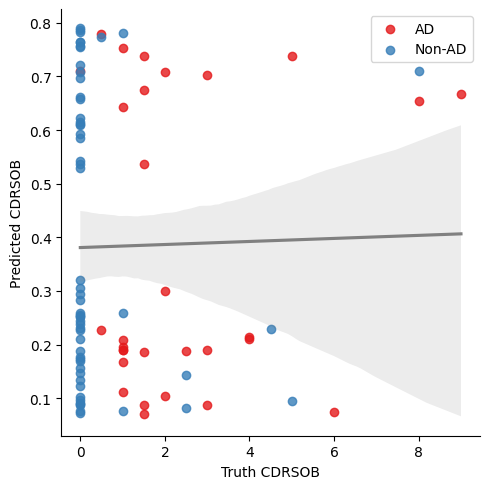

In [29]:
if flag_MMSE or flag_MMSE_Scaled: TITLE = "MMSE"
elif flag_CDR or flag_CDR_Scaled: TITLE = "CDR"
elif flag_CDRSOB or flag_CDRSOB_Scaled: TITLE = "CDRSOB"

result_df = pd.DataFrame()
result_df['Label'] = result_label
result_df['Truth '+TITLE] = result_ground_truth
result_df['Predicted '+TITLE] = result_prediction

slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Truth '+TITLE], result_df['Predicted '+TITLE])

hue_order = ['AD', 'Non-AD']
sns.lmplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette="Set1")
ax = sns.regplot(data=result_df, x="Truth "+TITLE, y="Predicted "+TITLE, scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
# if flag_MMSE or flag_MMSE_Scaled:
#     ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
#     ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
# if flag_CDR or flag_CDR_Scaled:
#     ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
#     ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
# if flag_CDRSOB or flag_CDRSOB_Scaled:
#     ax.set_xticks([0, 2, 4, 6, 8])
#     ax.set_yticks([0, 2, 4, 6, 8])  
ax.legend()

# Write to CSV file

In [30]:
score_walking_of_each_pid_sorted = {}

keys = list(score_walking_of_each_pid.keys())
keys.sort()
score_walking_of_each_pid_sorted = {i: score_walking_of_each_pid[i] for i in keys}

score_walking_of_each_pid_sorted[1]

{'Label': 0, 'Prediction': 0.78959316, 'Ground_Truth': 0.0}

In [31]:
def write_result_to_csv(data_dict, fileName):
    result_list = []
    for key in data_dict:
        pid = key
        prediction = data_dict[key]['Prediction']
        label = data_dict[key]['Label']
        ground_truth = data_dict[key]['Ground_Truth']
        result_list.append([pid, prediction, label, ground_truth])
        
    field_name = ['Pid', 'Prediction', 'Label', 'Ground_Truth']
    with open(fileName, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerow(field_name)
        write.writerows(result_list)

if flag_PreTrained==False:
    if flag_MMSE: filename = "Results/Walking_MMSE.csv"
    if flag_MMSE_Scaled: filename = "Results/Walking_MMSE_Scaled.csv"
    if flag_CDR: filename = "Results/Walking_CDR.csv"
    if flag_CDR_Scaled: filename = "Results/Walking_CDR_Scaled.csv"
    if flag_CDRSOB: filename = "Results/Walking_CDRSOB.csv"
    if flag_CDRSOB_Scaled: filename = "Results/Walking_CDRSOB_Scaled.csv"
elif flag_PreTrained==True:
    if flag_MMSE: filename = "Results/Walking_PreTrained_MMSE.csv"
    if flag_MMSE_Scaled: filename = "Results/Walking_PreTrained_MMSE_Scaled.csv"
    if flag_CDR: filename = "Results/Walking_PreTrained_CDR.csv"
    if flag_CDR_Scaled: filename = "Results/Walking_PreTrained_CDR_Scaled.csv"
    if flag_CDRSOB: filename = "Results/Walking_PreTrained_CDRSOB.csv"
    if flag_CDRSOB_Scaled: filename = "Results/Walking_PreTrained_CDRSOB_Scaled.csv"

write_result_to_csv(score_walking_of_each_pid_sorted, filename)
score_walking_of_each_pid_sorted

{1: {'Label': 0, 'Prediction': 0.78959316, 'Ground_Truth': 0.0},
 2: {'Label': 0, 'Prediction': 0.52944845, 'Ground_Truth': 0.0},
 3: {'Label': 0, 'Prediction': 0.7078542, 'Ground_Truth': 0.0},
 4: {'Label': 1, 'Prediction': 0.73820436, 'Ground_Truth': 1.5},
 5: {'Label': 0, 'Prediction': 0.2591045, 'Ground_Truth': 1.0},
 6: {'Label': 0, 'Prediction': 0.25053924, 'Ground_Truth': 0.0},
 7: {'Label': 0, 'Prediction': 0.09039059, 'Ground_Truth': 0.0},
 9: {'Label': 1, 'Prediction': 0.07381066, 'Ground_Truth': 6.0},
 10: {'Label': 1, 'Prediction': 0.19497924, 'Ground_Truth': 1.0},
 11: {'Label': 1, 'Prediction': 0.6666946, 'Ground_Truth': 9.0},
 12: {'Label': 1, 'Prediction': 0.16693525, 'Ground_Truth': 1.0},
 13: {'Label': 0, 'Prediction': 0.7641166, 'Ground_Truth': 0.0},
 16: {'Label': 1, 'Prediction': 0.19056565, 'Ground_Truth': 3.0},
 17: {'Label': 1, 'Prediction': 0.11057445, 'Ground_Truth': 1.0},
 18: {'Label': 1, 'Prediction': 0.06970946, 'Ground_Truth': 1.5},
 19: {'Label': 0, 'Pre

# --------------

# Training (Pre-trained)

In [34]:
MAX_EPOCHS = 50
BATCH_SIZE = 32

### Pre-Trained Model
LOAD_PRETRAINED = "../Walking Subtask/LOG_FS/Walking_RandomSeed_FS/10/Model_Weights/"

### Original Score
SAVE_MODEL_FOLDER = "LOG_Walking_PreTrained/MMSE/20240613_Adam_LossMAE_metricsMAE/"
# SAVE_MODEL_FOLDER = "LOG_Walking_PreTrained/CDR/20240613_Adam_LossMAE_metricsMAE/"
# SAVE_MODEL_FOLDER = "LOG_Walking_PreTrained/CDRSOB/20240613_Adam_LossMAE_metricsMAE/"

### Scaled Score
# SAVE_MODEL_FOLDER = "LOG_Walking_PreTrained/MMSE_Scaled/20240613_Adam_LossMAE_metricsMAE/"
# SAVE_MODEL_FOLDER = "LOG_Walking_PreTrained/CDR_Scaled/20240613_Adam_LossMAE_metricsMAE/"
# SAVE_MODEL_FOLDER = "LOG_Walking_PreTrained/CDRSOB_Scaled/20240613_Adam_LossMAE_metricsMAE/"


Training for [Fold 1] .....


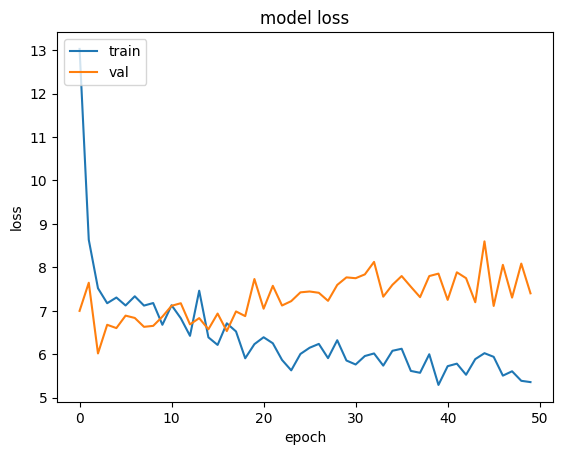

Training for [Fold 2] .....


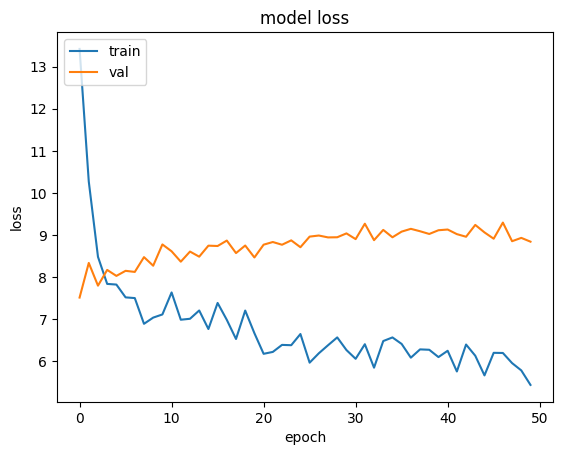

Training for [Fold 3] .....


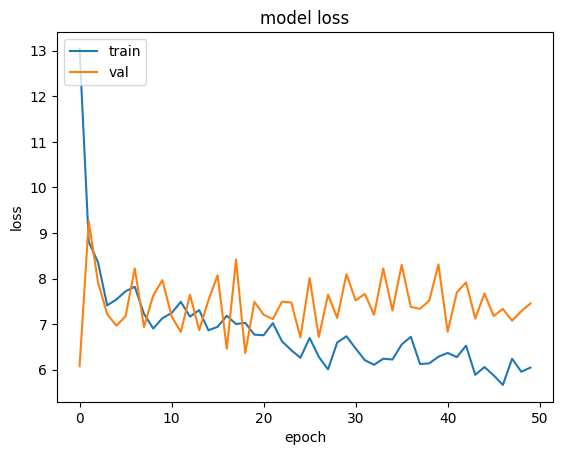

Training for [Fold 4] .....


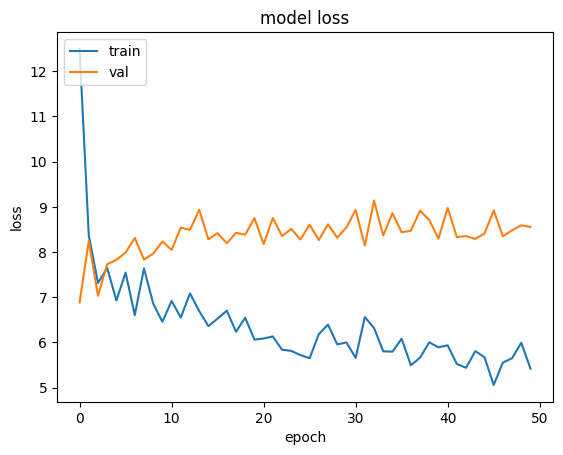

Training for [Fold 5] .....
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_input (InputLayer [(None, 9, 50, 1)]        0         
_________________________________________________________________
first_conv (Conv2D)          (None, 9, 50, 8)          32        
_________________________________________________________________
last_conv (Conv2D)           (None, 9, 50, 16)         400       
_________________________________________________________________
dropout_24 (Dropout)         (None, 9, 50, 16)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 7200)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                230432    
_________________________________________________________________
dropout_2 (Dropout)          (N

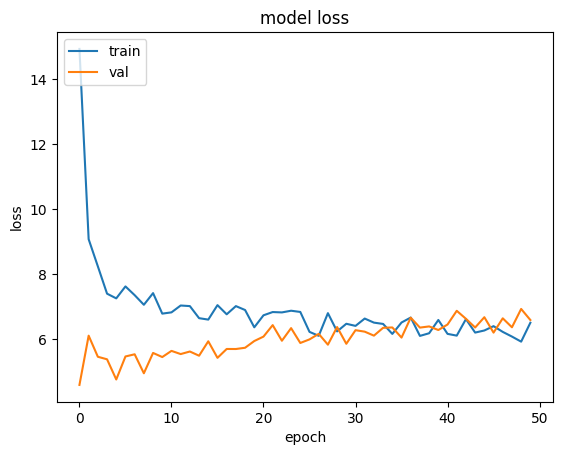

In [35]:
def training_model_Validation_data_Save_model():
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], xValidate_5f[fold_idx], yValidate_5f[fold_idx]

        xTrain_1f = xTrain_1f.reshape(-1, int(n_SELECTED_FEATURE), int(n_PERIOD), 1)
        xVal_1f = xVal_1f.reshape(-1, int(n_SELECTED_FEATURE), int(n_PERIOD), 1)

        print(f'Training for [Fold {fold_idx+1}] .....')

        pretrained_model = load_model(f"{LOAD_PRETRAINED}walking_model_Fold{fold_idx+1}.h5")
        # for layer in pretrained_model.layers[:-3]:
        #     layer.trainable = False
        x = pretrained_model.layers[-4].output
        x = Dense(32, activation='relu', name='dense_32')(x)
        x = Dropout(0.5, name='dropout_2')(x)
        outputs = Dense(1, activation='linear', name='dense_1')(x)
        model = Model(inputs=pretrained_model.input, outputs=outputs)
        # print(model.get_weights())
        # print(model.layers[-3].get_config())
        
        ### mse, mae, correlation, fft
        ### Adam
        model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
        # model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
        # model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

        ### RMSprop
        # model.compile(loss='mean_absolute_error', optimizer='RMSprop', metrics=['mae'])
        # model.compile(loss='mean_absolute_error', optimizer='RMSprop', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mae'])
        # model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mse'])

        history = model.fit(xTrain_1f, yTrain_1f, 
                            validation_data=(xVal_1f, yVal_1f), 
                            epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=0) # verbose=0

        ### Save model weights-----------------------------------------------------------------------------
        if not os.path.exists(SAVE_MODEL_FOLDER): os.makedirs(SAVE_MODEL_FOLDER)
        model.save(f'{SAVE_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        ### Show model structure ------------------------------------------------------------------------
        if fold_idx == n_FOLD-1:
            print(model.summary())

        ### Plot history loss -----------------------------------------------------------------------------
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


training_model_Validation_data_Save_model()

# Evaluate

## MMSE Score

In [36]:
# New model
# LOAD_MODEL_FOLDER = "LOG_Walking/MMSE/20240613_Adam_LossMAE_metricsMAE/"
# LOAD_MODEL_FOLDER = "LOG_Walking/MMSE_Scaled/20240613_Adam_LossMAE_metricsMAE/"

# Pre-trained
LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/MMSE/20240613_Adam_LossMAE_metricsMAE/"
# LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/MMSE_Scaled/20240613_Adam_LossMAE_metricsMAE/"


print(f'Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')

Load model weights from FOLDER: LOG_Walking_PreTrained/MMSE/20240613_Adam_LossMAE_metricsMAE/


In [37]:
avg_MMSE_of_each_pid = {}
result_label = []
result_ground_truth = []
result_avg_MMSE = []


def analyze_MMSE_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    # predictionList = MMSE_scaler.inverse_transform(predictionList)

    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        groundTruth = MMSE_dict[pid]

        score = 0
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                score += round(predictionList[j][0], 4)
        # avgScore = int(score / nPairs)
        avgScore = score / nPairs
        
        avg_MMSE_of_each_pid[pid] = {}
        avg_MMSE_of_each_pid[pid]["Label"] = label
        avg_MMSE_of_each_pid[pid]["Average MMSE"] = avgScore
        avg_MMSE_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_avg_MMSE.append(avgScore)
        print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {avgScore}')


def analyze_MMSE_weighted_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    # predictionList = MMSE_scaler.inverse_transform(predictionList)
    
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        groundTruth = MMSE_dict[pid]

        tmp_score_list = []
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                tmp_score_list.append(predictionList[j][0])

        print(f'[Pid {pid}, Label: {label}] {tmp_score_list}')
        if label==1:
            eps = sys.float_info.epsilon
            tmp_score_list = [w if w != 0 else eps for w in tmp_score_list]
            tmp_score_list = np.array(tmp_score_list)
            avgScore = np.average(tmp_score_list, weights=1/tmp_score_list)
        else:
            avgScore = np.average(tmp_score_list, weights=tmp_score_list)
        
        avg_MMSE_of_each_pid[pid] = {}
        avg_MMSE_of_each_pid[pid]["Label"] = label
        avg_MMSE_of_each_pid[pid]["Average MMSE"] = avgScore
        avg_MMSE_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_avg_MMSE.append(avgScore)
        print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {avgScore}')



def load_model_and_evaluate_model():
    rmse_5fold, mse_5fold, mae_5fold = [], [], []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')
        # model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5', 
        #                    custom_objects = {'correlation_coefficient_loss': correlation_coefficient_loss}) 

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        videoIdx_1f = videoIdx_5f[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, int(n_SELECTED_FEATURE), int(n_PERIOD), 1) 

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)


        # if np.isnan(xTest_1f): print('YES')
        # else: print('NO')

        # print(xTest_1f)
        score_rmse = np.sqrt(mean_squared_error(yPred, yTest_1f))
        score_mse = mean_squared_error(yPred, yTest_1f)
        score_mae = mean_absolute_error(yPred, yTest_1f)
        rmse_5fold.append(round(score_rmse, 2))
        mse_5fold.append(round(score_mse, 2))
        mae_5fold.append(round(score_mae, 2))
        
        analyze_MMSE_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
        # analyze_MMSE_weighted_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
    return rmse_5fold, mse_5fold, mae_5fold


rmse_5fold, mse_5fold, mae_5fold = load_model_and_evaluate_model()

[Pid 1] Label: 0, Truth: 30, Pred: 17.27186648050944
[Pid 2] Label: 0, Truth: 30, Pred: 21.54349994659424
[Pid 4] Label: 1, Truth: 23, Pred: 20.931799697875977
[Pid 11] Label: 1, Truth: 16, Pred: 22.436333338419598
[Pid 29] Label: 0, Truth: 30, Pred: 25.35925038655599
[Pid 34] Label: 0, Truth: 30, Pred: 22.612309022383258
[Pid 36] Label: 1, Truth: 8, Pred: 20.995058457056682
[Pid 37] Label: 1, Truth: 16, Pred: 23.850975275039673
[Pid 44] Label: 0, Truth: 30, Pred: 26.801249504089355
[Pid 45] Label: 1, Truth: 14, Pred: 22.827479934692384
[Pid 49] Label: 0, Truth: 30, Pred: 23.39629978603787
[Pid 59] Label: 1, Truth: 19, Pred: 21.25511016845703
[Pid 67] Label: 0, Truth: 24, Pred: 25.492324829101562
[Pid 75] Label: 0, Truth: 30, Pred: 27.352299690246582
[Pid 81] Label: 0, Truth: 30, Pred: 24.546039962768553
[Pid 83] Label: 0, Truth: 30, Pred: 29.094933827718098
[Pid 89] Label: 0, Truth: 30, Pred: 25.598866780598957
[Pid 94] Label: 0, Truth: 30, Pred: 25.57349967956543
[Pid 5] Label: 0, Tr

In [38]:
print(f'(1) RMSE: {rmse_5fold}')
print(f'(2) MSE: {mse_5fold}')
print(f'(3) MAE: {mae_5fold}')

(1) RMSE: [8.22, 7.5, 9.99, 7.04, 9.14]
(2) MSE: [67.54, 56.23, 99.78, 49.56, 83.48]
(3) MAE: [6.74, 6.3, 8.04, 6.09, 7.28]


In [39]:
avg_MMSE_of_each_pid

{1: {'Label': 0, 'Average MMSE': 17.27186648050944, 'Groud Truth': 30},
 2: {'Label': 0, 'Average MMSE': 21.54349994659424, 'Groud Truth': 30},
 4: {'Label': 1, 'Average MMSE': 20.931799697875977, 'Groud Truth': 23},
 11: {'Label': 1, 'Average MMSE': 22.436333338419598, 'Groud Truth': 16},
 29: {'Label': 0, 'Average MMSE': 25.35925038655599, 'Groud Truth': 30},
 34: {'Label': 0, 'Average MMSE': 22.612309022383258, 'Groud Truth': 30},
 36: {'Label': 1, 'Average MMSE': 20.995058457056682, 'Groud Truth': 8},
 37: {'Label': 1, 'Average MMSE': 23.850975275039673, 'Groud Truth': 16},
 44: {'Label': 0, 'Average MMSE': 26.801249504089355, 'Groud Truth': 30},
 45: {'Label': 1, 'Average MMSE': 22.827479934692384, 'Groud Truth': 14},
 49: {'Label': 0, 'Average MMSE': 23.39629978603787, 'Groud Truth': 30},
 59: {'Label': 1, 'Average MMSE': 21.25511016845703, 'Groud Truth': 19},
 67: {'Label': 0, 'Average MMSE': 25.492324829101562, 'Groud Truth': 24},
 75: {'Label': 0, 'Average MMSE': 27.3522996902

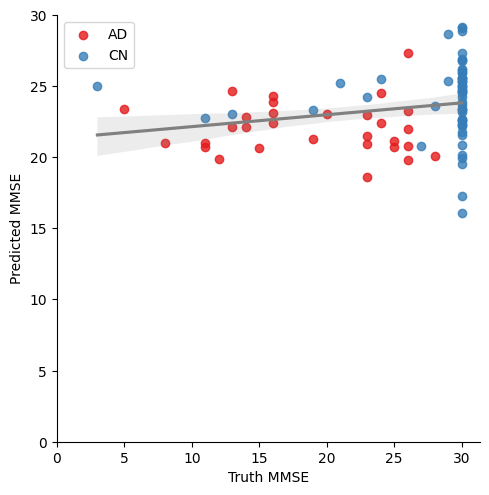

In [40]:
result_df = pd.DataFrame()
result_df['Label'] = result_label
result_df['Truth MMSE'] = result_ground_truth
result_df['Predicted MMSE'] = result_avg_MMSE

slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Truth MMSE'], result_df['Predicted MMSE'])

hue_order = ['AD', 'CN']
sns.lmplot(data=result_df, x="Truth MMSE", y="Predicted MMSE", hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette="Set1")
ax = sns.regplot(data=result_df, x="Truth MMSE", y="Predicted MMSE", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
ax.legend()

## CDR Score

In [24]:
# New model
# LOAD_MODEL_FOLDER = "LOG_Walking/CDR/20240613_Adam_LossMAE_metricsMAE/"
# LOAD_MODEL_FOLDER = "LOG_Walking/CDR_Scaled/20240613_Adam_LossMAE_metricsMAE/"

# Pre-trained
LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/CDR/20240613_Adam_LossMAE_metricsMAE/"
# LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/CDR_Scaled/20240613_Adam_LossMAE_metricsMAE/"


print(f'Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')

Load model weights from FOLDER: LOG_Walking_PreTrained/CDR/20240613_Adam_LossMAE_metricsMAE/


In [29]:
avg_CDR_of_each_pid = {}

result_label = []
result_ground_truth = []
result_avg_CDR = []


def analyze_CDR_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    # predictionList = CDR_scaler.inverse_transform(predictionList)
    
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        groundTruth = CDR_dict[pid]

        score = 0
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                score += round(predictionList[j][0], 4)
        # avgScore = int(score / nPairs)
        avgScore = score / nPairs
        
        avg_CDR_of_each_pid[pid] = {}
        avg_CDR_of_each_pid[pid]["Label"] = label
        avg_CDR_of_each_pid[pid]["Average CDR"] = avgScore
        avg_CDR_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_avg_CDR.append(avgScore)
        print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {avgScore}')


def analyze_CDR_weighted_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    # predictionList = CDR_scaler.inverse_transform(predictionList)

    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        groundTruth = CDR_dict[pid]

        score_list = []
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                score_list.append(predictionList[j][0])

        if label==0:
            eps = sys.float_info.epsilon
            score_list = [w if w != 0 else eps for w in score_list]
            score_list = np.array(score_list)
            avgScore = np.average(score_list, weights=1/score_list)
        else:
            avgScore = np.average(score_list, weights=score_list)
        
        avg_CDR_of_each_pid[pid] = {}
        avg_CDR_of_each_pid[pid]["Label"] = label
        avg_CDR_of_each_pid[pid]["Average CDR"] = avgScore
        avg_CDR_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_avg_CDR.append(avgScore)
        print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {avgScore}')



def load_model_and_evaluate_model():
    rmse_5fold, mse_5fold, mae_5fold = [], [], []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        videoIdx_1f = videoIdx_5f[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, int(n_SELECTED_FEATURE), int(n_PERIOD), 1) 

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)
        score_rmse = np.sqrt(mean_squared_error(yPred, yTest_1f))
        score_mse = mean_squared_error(yPred, yTest_1f)
        score_mae = mean_absolute_error(yPred, yTest_1f)
        rmse_5fold.append(round(score_rmse, 2))
        mse_5fold.append(round(score_mse, 2))
        mae_5fold.append(round(score_mae, 2))
        
        # analyze_CDR_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
        analyze_CDR_weighted_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
    return rmse_5fold, mse_5fold, mae_5fold


rmse_5fold, mse_5fold, mae_5fold = load_model_and_evaluate_model()

[Pid 1] Label: 0, Truth: 0.0, Pred: 0.3339318633079529
[Pid 2] Label: 0, Truth: 0.0, Pred: 0.021599391475319862
[Pid 4] Label: 1, Truth: 0.5, Pred: 0.3778412938117981
[Pid 11] Label: 1, Truth: 1.0, Pred: 0.34508809447288513
[Pid 29] Label: 0, Truth: 0.0, Pred: 0.03792434185743332
[Pid 34] Label: 0, Truth: 0.0, Pred: -6.052748722140677e-05
[Pid 36] Label: 1, Truth: 1.0, Pred: 0.5445192456245422
[Pid 37] Label: 1, Truth: 0.5, Pred: 0.4380774199962616
[Pid 44] Label: 0, Truth: 0.0, Pred: -2.2042197088012472e-05
[Pid 45] Label: 1, Truth: 0.5, Pred: 0.2698463499546051
[Pid 49] Label: 0, Truth: 0.0, Pred: -4.9581176426727325e-05
[Pid 59] Label: 1, Truth: 0.5, Pred: 0.45144662261009216
[Pid 75] Label: 0, Truth: 0.0, Pred: -1.099829842132749e-05
[Pid 81] Label: 0, Truth: 0.0, Pred: -2.750840940279886e-05
[Pid 83] Label: 0, Truth: 0.0, Pred: 0.0009128592209890485
[Pid 89] Label: 0, Truth: 0.0, Pred: 0.01371041964739561
[Pid 94] Label: 0, Truth: 0.0, Pred: 0.14675258100032806
[Pid 5] Label: 0, T

In [30]:
print(f'(1) RMSE: {rmse_5fold}')
print(f'(2) MSE: {mse_5fold}')
print(f'(3) MAE: {mae_5fold}')

(1) RMSE: [0.42, 0.31, 0.37, 0.25, 0.65]
(2) MSE: [0.18, 0.1, 0.14, 0.06, 0.42]
(3) MAE: [0.31, 0.26, 0.28, 0.19, 0.4]


In [31]:
avg_CDR_of_each_pid

{1: {'Label': 0, 'Average CDR': 0.33393186, 'Groud Truth': 0.0},
 2: {'Label': 0, 'Average CDR': 0.021599391, 'Groud Truth': 0.0},
 4: {'Label': 1, 'Average CDR': 0.3778413, 'Groud Truth': 0.5},
 11: {'Label': 1, 'Average CDR': 0.3450881, 'Groud Truth': 1.0},
 29: {'Label': 0, 'Average CDR': 0.03792434, 'Groud Truth': 0.0},
 34: {'Label': 0, 'Average CDR': -6.0527487e-05, 'Groud Truth': 0.0},
 36: {'Label': 1, 'Average CDR': 0.54451925, 'Groud Truth': 1.0},
 37: {'Label': 1, 'Average CDR': 0.43807742, 'Groud Truth': 0.5},
 44: {'Label': 0, 'Average CDR': -2.2042197e-05, 'Groud Truth': 0.0},
 45: {'Label': 1, 'Average CDR': 0.26984635, 'Groud Truth': 0.5},
 49: {'Label': 0, 'Average CDR': -4.9581176e-05, 'Groud Truth': 0.0},
 59: {'Label': 1, 'Average CDR': 0.45144662, 'Groud Truth': 0.5},
 75: {'Label': 0, 'Average CDR': -1.0998298e-05, 'Groud Truth': 0.0},
 81: {'Label': 0, 'Average CDR': -2.750841e-05, 'Groud Truth': 0.0},
 83: {'Label': 0, 'Average CDR': 0.0009128592, 'Groud Truth':

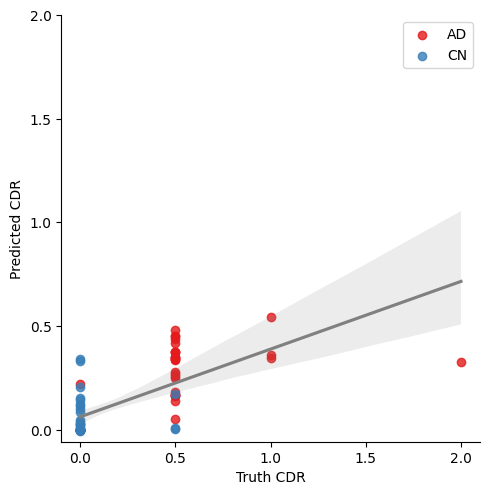

In [32]:
result_df = pd.DataFrame()
result_df['Label'] = result_label
result_df['Truth CDR'] = result_ground_truth
result_df['Predicted CDR'] = result_avg_CDR

slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Truth CDR'], result_df['Predicted CDR'])


hue_order = ['AD', 'CN']
sns.lmplot(data=result_df, x="Truth CDR", y="Predicted CDR", hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette="Set1")
ax = sns.regplot(data=result_df, x="Truth CDR", y="Predicted CDR", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
ax.legend()

## CDR-SOB Score

In [24]:
# New model
# LOAD_MODEL_FOLDER = "LOG_Walking/CDRSOB/20240613_Adam_LossMAE_metricsMAE/"
# LOAD_MODEL_FOLDER = "LOG_Walking/CDRSOB_Scaled/20240613_Adam_LossMAE_metricsMAE/"

# Pre-trained
LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/CDRSOB/20240613_Adam_LossMAE_metricsMAE/"
# LOAD_MODEL_FOLDER = "LOG_Walking_PreTrained/CDRSOB_Scaled/20240613_Adam_LossMAE_metricsMAE/"

print(f'Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')

Load model weights from FOLDER: LOG_Walking_PreTrained/CDRSOB/20240613_Adam_LossMAE_metricsMAE/


In [29]:
avg_CDRSOB_of_each_pid = {}
result_label = []
result_ground_truth = []
result_avg_CDRSOB = []


def analyze_CDRSOB_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    # predictionList = CDRSOB_scaler.inverse_transform(predictionList)

    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        groundTruth = CDRSOB_dict[pid]

        score = 0
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                score += round(predictionList[j][0], 4)
        # avgScore = int(score / nPairs)
        avgScore = score / nPairs
        
        avg_CDRSOB_of_each_pid[pid] = {}
        avg_CDRSOB_of_each_pid[pid]["Label"] = label
        avg_CDRSOB_of_each_pid[pid]["Average CDR-SOB"] = avgScore
        avg_CDRSOB_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_avg_CDRSOB.append(avgScore)
        print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {avgScore}')


def analyze_CDRSOB_weighted_score_of_each_subject(idxList, answerList, predictionList):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)

    # predictionList = CDRSOB_scaler.inverse_transform(predictionList)
    
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        label = Label_dict[pid]
        groundTruth = CDRSOB_dict[pid]

        tmp_score_list = []
        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                tmp_score_list.append(predictionList[j][0])

        print(f'[Pid {pid}, Label: {label}] {tmp_score_list}')
        if label==1:
            eps = sys.float_info.epsilon
            tmp_score_list = [w if w != 0 else eps for w in tmp_score_list]
            tmp_score_list = np.array(tmp_score_list)
            avgScore = np.average(tmp_score_list, weights=1/tmp_score_list)
        else:
            avgScore = np.average(tmp_score_list, weights=tmp_score_list)
        
        avg_CDRSOB_of_each_pid[pid] = {}
        avg_CDRSOB_of_each_pid[pid]["Label"] = label
        avg_CDRSOB_of_each_pid[pid]["Average CDR-SOB"] = avgScore
        avg_CDRSOB_of_each_pid[pid]["Groud Truth"] = groundTruth

        if label==1: result_label.append('AD')
        if label==0: result_label.append('CN')
        result_ground_truth.append(groundTruth)
        result_avg_CDRSOB.append(avgScore)
        print(f'[Pid {pid}] Label: {label}, Truth: {groundTruth}, Pred: {avgScore}')


def load_model_and_evaluate_model():
    rmse_5fold, mse_5fold, mae_5fold = [], [], []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        videoIdx_1f = videoIdx_5f[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, int(n_SELECTED_FEATURE), int(n_PERIOD), 1) 

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)
        score_rmse = np.sqrt(mean_squared_error(yPred, yTest_1f))
        score_mse = mean_squared_error(yPred, yTest_1f)
        score_mae = mean_absolute_error(yPred, yTest_1f)
        rmse_5fold.append(round(score_rmse, 2))
        mse_5fold.append(round(score_mse, 2))
        mae_5fold.append(round(score_mae, 2))

        analyze_CDRSOB_score_of_each_subject(idxTest_1f, yTest_1f, yPred)
        # analyze_CDRSOB_weighted_score_of_each_subject(idxTest_1f, yTest_1f, yPred)

    return rmse_5fold, mse_5fold, mae_5fold


rmse_5fold, mse_5fold, mae_5fold = load_model_and_evaluate_model()

[Pid 1] Label: 0, Truth: 0.0, Pred: 1.9381333192189534
[Pid 2] Label: 0, Truth: 0.0, Pred: 0.25254999846220016
[Pid 4] Label: 1, Truth: 1.5, Pred: 1.8201000034809112
[Pid 11] Label: 1, Truth: 9.0, Pred: 1.1042999923229218
[Pid 29] Label: 0, Truth: 0.0, Pred: 0.836750008961341
[Pid 34] Label: 0, Truth: 0.0, Pred: 1.0017545535282062
[Pid 36] Label: 1, Truth: 8.0, Pred: 1.654758343870829
[Pid 37] Label: 1, Truth: 1.5, Pred: 0.7004874913400272
[Pid 44] Label: 0, Truth: 0.0, Pred: 0.2699500048911432
[Pid 45] Label: 1, Truth: 1.5, Pred: 1.0892000272870064
[Pid 49] Label: 0, Truth: 0.0, Pred: 0.5836000004912623
[Pid 59] Label: 1, Truth: 1.0, Pred: 1.9470099657773972
[Pid 75] Label: 0, Truth: 0.0, Pred: 0.008800000214250758
[Pid 81] Label: 0, Truth: 0.0, Pred: 0.2932199915056117
[Pid 83] Label: 0, Truth: 0.0, Pred: 0.09643333529432614
[Pid 89] Label: 0, Truth: 0.0, Pred: 0.897399989888072
[Pid 94] Label: 0, Truth: 0.0, Pred: 0.5748499929904938
[Pid 5] Label: 0, Truth: 1.0, Pred: 0.858721425828

In [30]:
print(f'(1) RMSE: {rmse_5fold}')
print(f'(2) MSE: {mse_5fold}')
print(f'(3) MAE: {mae_5fold}')

(1) RMSE: [3.47, 1.29, 2.11, 1.46, 2.18]
(2) MSE: [12.07, 1.66, 4.46, 2.14, 4.74]
(3) MAE: [2.15, 0.94, 1.45, 1.0, 1.56]


In [31]:
avg_CDRSOB_of_each_pid

{1: {'Label': 0, 'Average CDR-SOB': 1.9381333192189534, 'Groud Truth': 0.0},
 2: {'Label': 0, 'Average CDR-SOB': 0.25254999846220016, 'Groud Truth': 0.0},
 4: {'Label': 1, 'Average CDR-SOB': 1.8201000034809112, 'Groud Truth': 1.5},
 11: {'Label': 1, 'Average CDR-SOB': 1.1042999923229218, 'Groud Truth': 9.0},
 29: {'Label': 0, 'Average CDR-SOB': 0.836750008961341, 'Groud Truth': 0.0},
 34: {'Label': 0, 'Average CDR-SOB': 1.0017545535282062, 'Groud Truth': 0.0},
 36: {'Label': 1, 'Average CDR-SOB': 1.654758343870829, 'Groud Truth': 8.0},
 37: {'Label': 1, 'Average CDR-SOB': 0.7004874913400272, 'Groud Truth': 1.5},
 44: {'Label': 0, 'Average CDR-SOB': 0.2699500048911432, 'Groud Truth': 0.0},
 45: {'Label': 1, 'Average CDR-SOB': 1.0892000272870064, 'Groud Truth': 1.5},
 49: {'Label': 0, 'Average CDR-SOB': 0.5836000004912623, 'Groud Truth': 0.0},
 59: {'Label': 1, 'Average CDR-SOB': 1.9470099657773972, 'Groud Truth': 1.0},
 75: {'Label': 0, 'Average CDR-SOB': 0.008800000214250758, 'Groud Tr

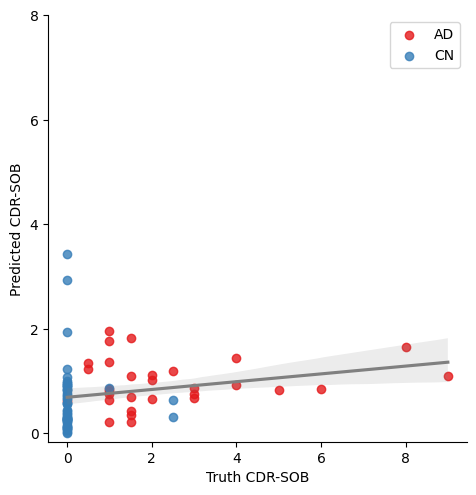

In [32]:
result_df = pd.DataFrame()
result_df['Label'] = result_label
result_df['Truth CDR-SOB'] = result_ground_truth
result_df['Predicted CDR-SOB'] = result_avg_CDRSOB

slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Truth CDR-SOB'], result_df['Predicted CDR-SOB'])


hue_order = ['AD', 'CN']
sns.lmplot(data=result_df, x="Truth CDR-SOB", y="Predicted CDR-SOB", hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette="Set1")
ax = sns.regplot(data=result_df, x="Truth CDR-SOB", y="Predicted CDR-SOB", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
ax.set_xticks([0, 2, 4, 6, 8])
ax.set_yticks([0, 2, 4, 6, 8])
ax.legend()